In [1]:
import os, tempfile
import logging
import matplotlib.pyplot as plt

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [6]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin,
                                        sakakibara_rec)
from experiments.ina_schneider import (schneider_taum,
                                       #schneider_taus,
                                       schneider_inact)

In [7]:
modelfile = 'models/standardised_ina.mmt'

## Activation only

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum)
                                                #sakakibara_inact,
                                                #schneider_inact,
                                                #sakakibara_inact_kin,
                                                #schneider_taus,
                                                #sakakibara_rec)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

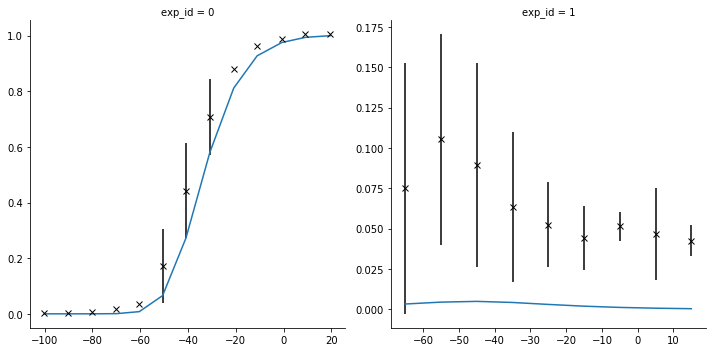

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum)
                     #sakakibara_inact,
                     #schneider_inact,
                     #sakakibara_inact_kin,
                     #schneider_taus,
                     #sakakibara_rec)

In [12]:
limits = {#'ina.S': (0., 1.),
          #'log_ina.A': (0, 2),
          'log_ina.p_1': (-7., 3.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-7., 3.),
          'ina.p_4': (1e-7, 0.4)}
          #'log_ina.p_5': (-2, 0.),
          #'ina.p_6': (1e-7, 0.1),
          #'log_ina.p_7': (-6., -4.),
          #'ina.p_8': (1e-7, 0.1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [13]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_ina_activation.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 16 particles


In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(100),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5570757359362264, '1': 1.5570757359362264, '2': 1.5570757359362264, '3': 1.5570757359362264, '4': 1.5570757359362264, '5': 0.5904911622959486, '6': 0.45939980914873735, '7': 0.5710013425594168, '8': 1.5570757359362264, '9': 1.5570757359362264, '10': 1.5570757359362264, '11': 1.5570757359362264, '12': 1.5570757359362264, '13': 0.15235445469736852, '14': 0.1819349064747563, '15': 0.1879980741832115, '16': 0.25507625823484376, '17': 0.4491978085688121, '18': 0.5936989296806218, '19': 1.3185718986681156, '20': 0.4160669679218102, '21': 1.2534510282040947}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-25 14:11:38.226962, end_time=None)>


In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 1579
DEBUG:Epsilon:new eps, t=1, eps=3.109980525319626
INFO:ABC:t:1 eps:3.109980525319626
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 2062
DEBUG:Epsilon:new eps, t=2, eps=2.5052094804872103
INFO:ABC:t:2 eps:2.5052094804872103
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 2608
DEBUG:Epsilon:new eps, t=3, eps=1.6878124971449593
INFO:ABC:t:3 eps:1.6878124971449593
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 2855
DEBUG:Epsilon:new eps, t=4, eps=0.9576062451139227
INFO:ABC:t:4 eps:0.9576062451139227
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 3117
DEBUG:Epsilon:new eps, t=5, eps=0.84808180477316

DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 23341
DEBUG:Epsilon:new eps, t=40, eps=0.17429597433368937
INFO:ABC:t:40 eps:0.17429597433368937
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 27498
DEBUG:Epsilon:new eps, t=41, eps=0.17426670286271667
INFO:ABC:t:41 eps:0.17426670286271667
DEBUG:ABC:now submitting population 41
DEBUG:ABC:population 41 done
DEBUG:ABC:
total nr simulations up to t =41 is 32739
DEBUG:Epsilon:new eps, t=42, eps=0.17423250580284783
INFO:ABC:t:42 eps:0.17423250580284783
DEBUG:ABC:now submitting population 42
DEBUG:ABC:population 42 done
DEBUG:ABC:
total nr simulations up to t =42 is 40084
DEBUG:Epsilon:new eps, t=43, eps=0.17423086595753795
INFO:ABC:t:43 eps:0.17423086595753795
DEBUG:ABC:now submitting population 43
DEBUG:ABC:population 43 done
DEBUG:ABC:
total nr simulations up to t =43 is 48457
DEBUG:Epsilon:new eps, t=44, eps=0.17419039718038917
INFO:ABC:t:44 eps

### Results analysis

In [21]:
history = History(db_path)

In [22]:
df, w = history.get_distribution(m=0)

In [28]:
df.describe()

name,ina.p_2,ina.p_4,log_ina.p_1,log_ina.p_3
count,100.000000,100.000000,100.000000,100.000000
mean,0.014383,0.058153,1.307203,-0.400492
std,0.000161,0.000148,0.000918,0.002862
min,0.013995,0.057877,1.305359,-0.410984
25%,0.014284,0.058054,1.306582,-0.401638
50%,0.014382,0.058139,1.307176,-0.400146
75%,0.014495,0.058236,1.307633,-0.398648
max,0.014743,0.058520,1.309725,-0.393567


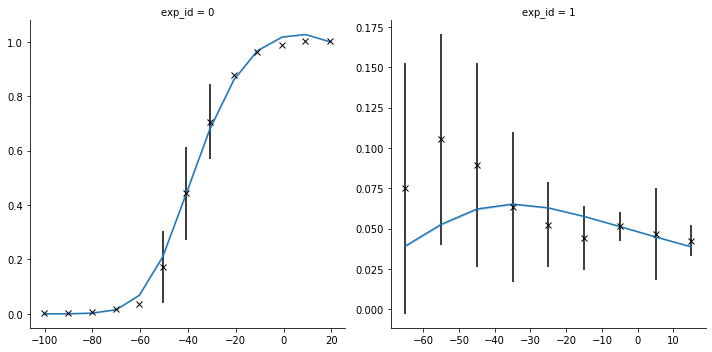

In [23]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     #sakakibara_inact,
                     #schneider_inact,
                     #sakakibara_inact_kin,
                     #schneider_taus,
                     #sakakibara_rec,
                     df=df, w=w)

In [24]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [25]:
m,_,_ = myokit.load(modelfile)

In [26]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

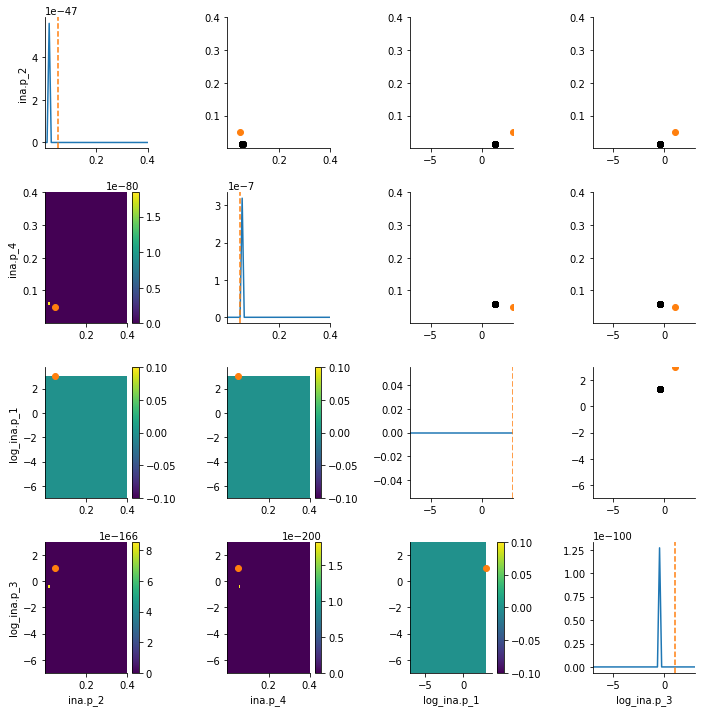

In [27]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

## Inactivation only

The model has been adjusted to use the mean values of activation parameters from the run above.

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                #sakakibara_act,
                                                #schneider_taum)
                                                #sakakibara_inact,
                                                schneider_inact,
                                                sakakibara_inact_kin,
                                                schneider_taus,
                                                sakakibara_rec)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

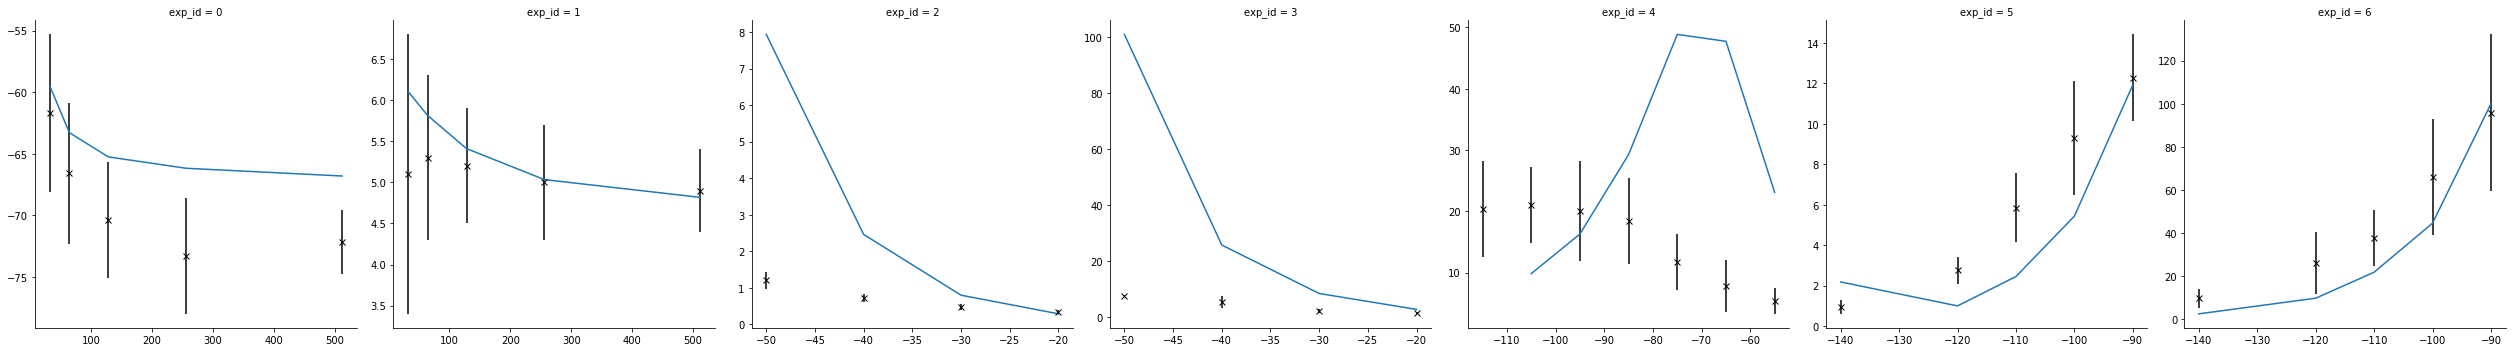

In [8]:
g = plot_sim_results(modelfile,
                     #sakakibara_act,
                     #schneider_taum)
                     #sakakibara_inact,
                     schneider_inact,
                     sakakibara_inact_kin,
                     schneider_taus,
                     sakakibara_rec)

In [9]:
limits = {'ina.S': (0., 1.),
          'log_ina.A': (0, 2),
          #'log_ina.p_1': (-7., 3.),
          #'ina.p_2': (1e-7, 0.4),
          #'log_ina.p_3': (-7., 3.),
          #'ina.p_4': (1e-7, 0.4)}
          'log_ina.p_5': (-2., 3.), # from analysis of Boltzmann inactivation, p_6+p_8 ~= 0.2 and p_5 must be 
          'ina.p_6': (1e-7, 0.2),   # six orders of magnitude larger than p_7.
          'log_ina.p_7': (-7., -2.),
          'ina.p_8': (1e-7, 0.2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_ina_inactivation.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(100),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.1195878030810285, '1': 1.2570810420558916, '2': 1.5245450935571452, '3': 1.5245450935571452, '4': 1.9550782918741014, '5': 0.3047622043215511, '6': 0.5180957473466369, '7': 0.740136781923767, '8': 0.740136781923767, '9': 1.0361914946932738, '10': 0.6384226829351632, '11': 1.2568946570286024, '12': 1.7487230010832733, '13': 2.4438478648426267, '14': 2.4438478648426267, '15': 0.44868962599637907, '16': 1.27876543408968, '17': 2.4438478648426267, '18': 0.18829336098901556, '19': 0.23789790841062497, '20': 0.17987205788010574, '21': 0.20970804540415242, '22': 0.32181072269500666, '23': 0.3443477469568021, '24': 0.7079687356759897, '25': 1.9550782918741014, '26': 1.81712476608753, '27': 0.7066313875850472, '28': 0.4264752039307583, '29': 0.5584662379876189, '30': 1.9550782918741014, '31': 0.6509350765610654, '32': 0.7106986592761048, '33': 0.34809678651604004, '34': 0.2583173903006488}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_m

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-25 20:21:18.897100, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Results analysis

In [17]:
history = History(db_path)

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ina.S,ina.p_6,ina.p_8,log_ina.A,log_ina.p_5,log_ina.p_7
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.868947,0.110733,0.052391,0.643041,2.213002,-3.197716
std,0.001301,0.000173,0.000501,0.001220,0.003660,0.022763
min,0.861878,0.110551,0.051187,0.641507,2.210265,-3.248997
25%,0.868798,0.110666,0.052040,0.642546,2.211898,-3.211870
50%,0.869051,0.110706,0.052442,0.642959,2.212549,-3.197908
75%,0.869508,0.110754,0.052710,0.643209,2.212989,-3.184935
max,0.870168,0.111751,0.053409,0.649551,2.234518,-3.138934


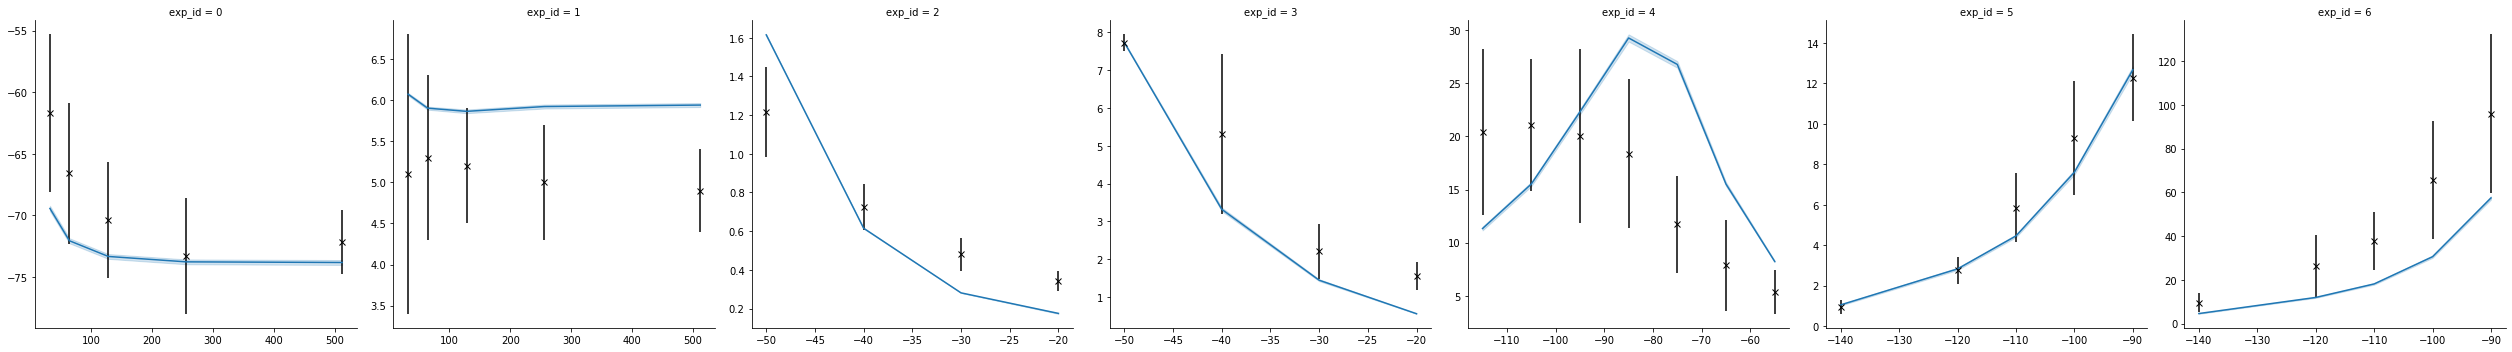

In [20]:
g = plot_sim_results(modelfile,
                     #sakakibara_act,
                     #schneider_taum,
                     #sakakibara_inact,
                     schneider_inact,
                     sakakibara_inact_kin,
                     schneider_taus,
                     sakakibara_rec,
                     df=df, w=w)

In [21]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [22]:
m,_,_ = myokit.load(modelfile)

In [23]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

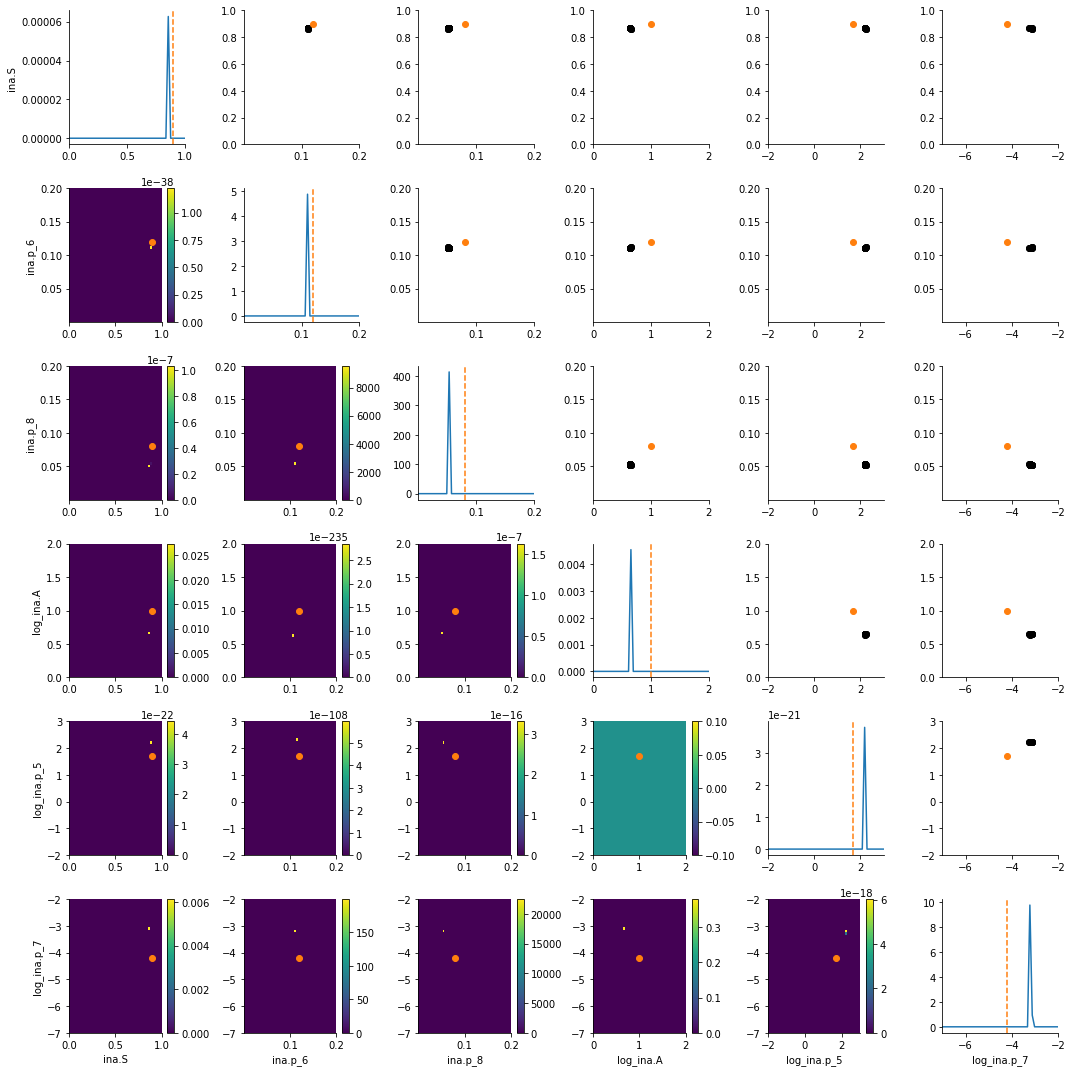

In [24]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

## Full dataset

In [29]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                schneider_taum,
                                                schneider_inact,
                                                sakakibara_inact_kin,
                                                #schneider_taus,
                                                sakakibara_rec)

In [30]:
assert len(observations)==len(summary_statistics(model({})))

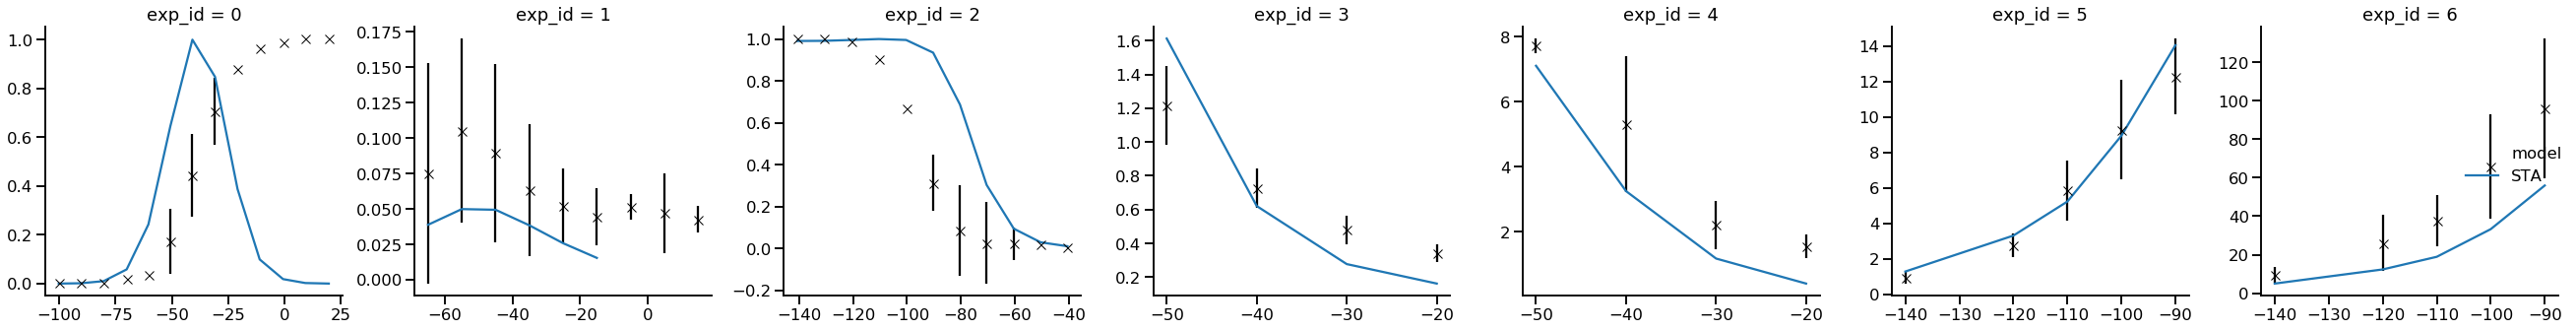

In [31]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     #schneider_inact,
                     sakakibara_inact_kin,
                     #schneider_taus,
                     sakakibara_rec)

In [32]:
limits = {'ina.S': (0., 1.),
          'log_ina.A': (0., 1.),
          'log_ina.p_1': (0., 3.),
          'ina.p_2': (1e-7, 0.2),
          'log_ina.p_3': (-3., 2.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (0., 3.),
          'ina.p_6': (1e-7, 0.2),
          'log_ina.p_7': (-5., -2.),
          'ina.p_8': (1e-7, 0.2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [33]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_ina_full.db"))

In [34]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [35]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [36]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.8994387935145443, '1': 0.8994387935145443, '2': 0.8994387935145443, '3': 0.8994387935145443, '4': 0.8994387935145443, '5': 0.34109494248661376, '6': 0.26537052793588445, '7': 0.32983672328438474, '8': 0.8994387935145443, '9': 0.8994387935145443, '10': 0.8994387935145443, '11': 0.8994387935145443, '12': 0.8994387935145443, '13': 1.0629731196080978, '14': 1.0629731196080978, '15': 1.0629731196080978, '16': 1.0629731196080978, '17': 1.0629731196080978, '18': 0.3987161257732702, '19': 0.2477787758193123, '20': 0.2744406241533312, '21': 0.6846716015655817, '22': 1.0629731196080978, '23': 1.0629731196080978, '24': 0.0880069631533838, '25': 0.10509399703633843, '26': 0.10859636247862713, '27': 0.14734381678808003, '28': 0.25947738164809303, '29': 0.34294789694461314, '30': 0.7616679717811788, '31': 0.24033947932778965, '32': 0.7240511521166183, '33': 1.3391800411562642, '34': 1.5036407479649283, '35': 1.8235643113617217, '36': 1.8235643113617217, '37': 2

In [37]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [38]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=7, start_time=2019-10-07 09:20:07.543703, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Results analysis

In [20]:
history = History(db_path)

In [21]:
df, w = history.get_distribution(m=0)

In [22]:
df.describe()

name,ina.S,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.A,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.315730,0.084863,0.084734,0.095341,0.066504,0.775100,2.187304,-0.517952,1.943268,-3.831732
std,0.151112,0.006709,0.039678,0.001698,0.009290,0.039241,0.145639,0.652146,0.056893,0.384680
min,0.052389,0.062452,0.000415,0.090463,0.046825,0.618198,1.616679,-2.815931,1.781943,-4.982436
25%,0.201862,0.080244,0.052914,0.094174,0.060163,0.747947,2.087677,-0.946104,1.902732,-4.065018
50%,0.294269,0.084874,0.082838,0.095227,0.064600,0.776418,2.198327,-0.479884,1.940365,-3.767518
75%,0.405404,0.089423,0.114799,0.096370,0.071654,0.802065,2.289704,-0.008776,1.982162,-3.579006
max,0.903014,0.104220,0.213133,0.102841,0.100540,0.887315,2.587457,1.097501,2.207809,-2.906290


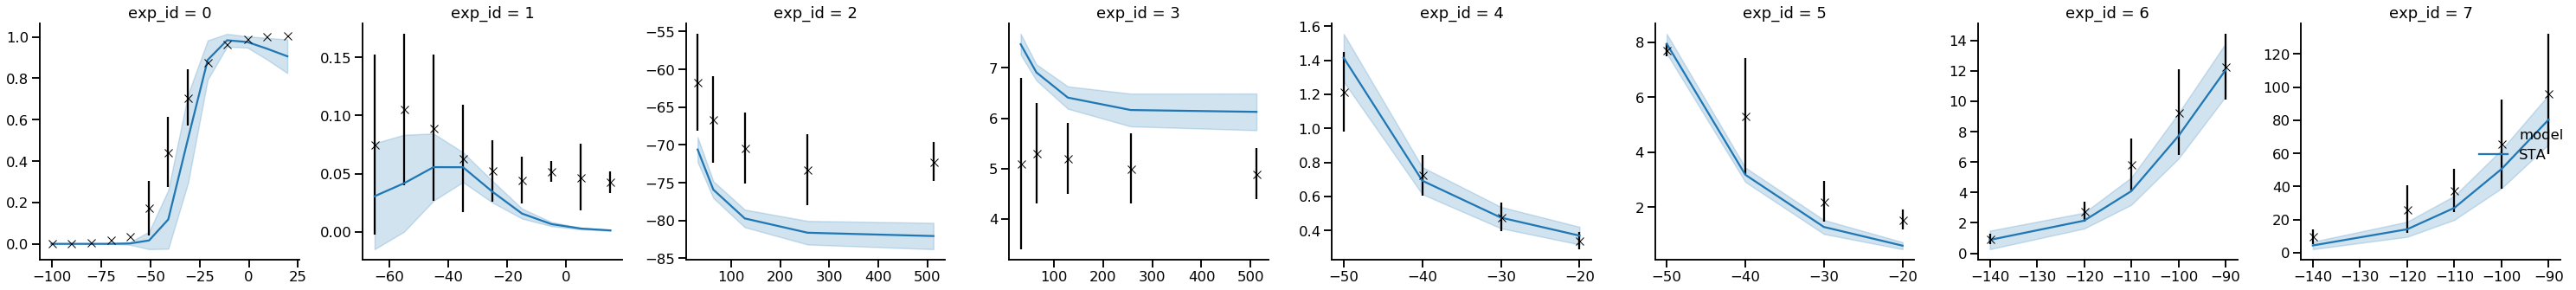

In [23]:
import seaborn as sns
sns.set_context('talk')

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     schneider_inact,
                     sakakibara_inact_kin,
                     #schneider_taus,
                     sakakibara_rec,
                     df=df, w=w)

In [24]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [25]:
m,_,_ = myokit.load(modelfile)

In [26]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

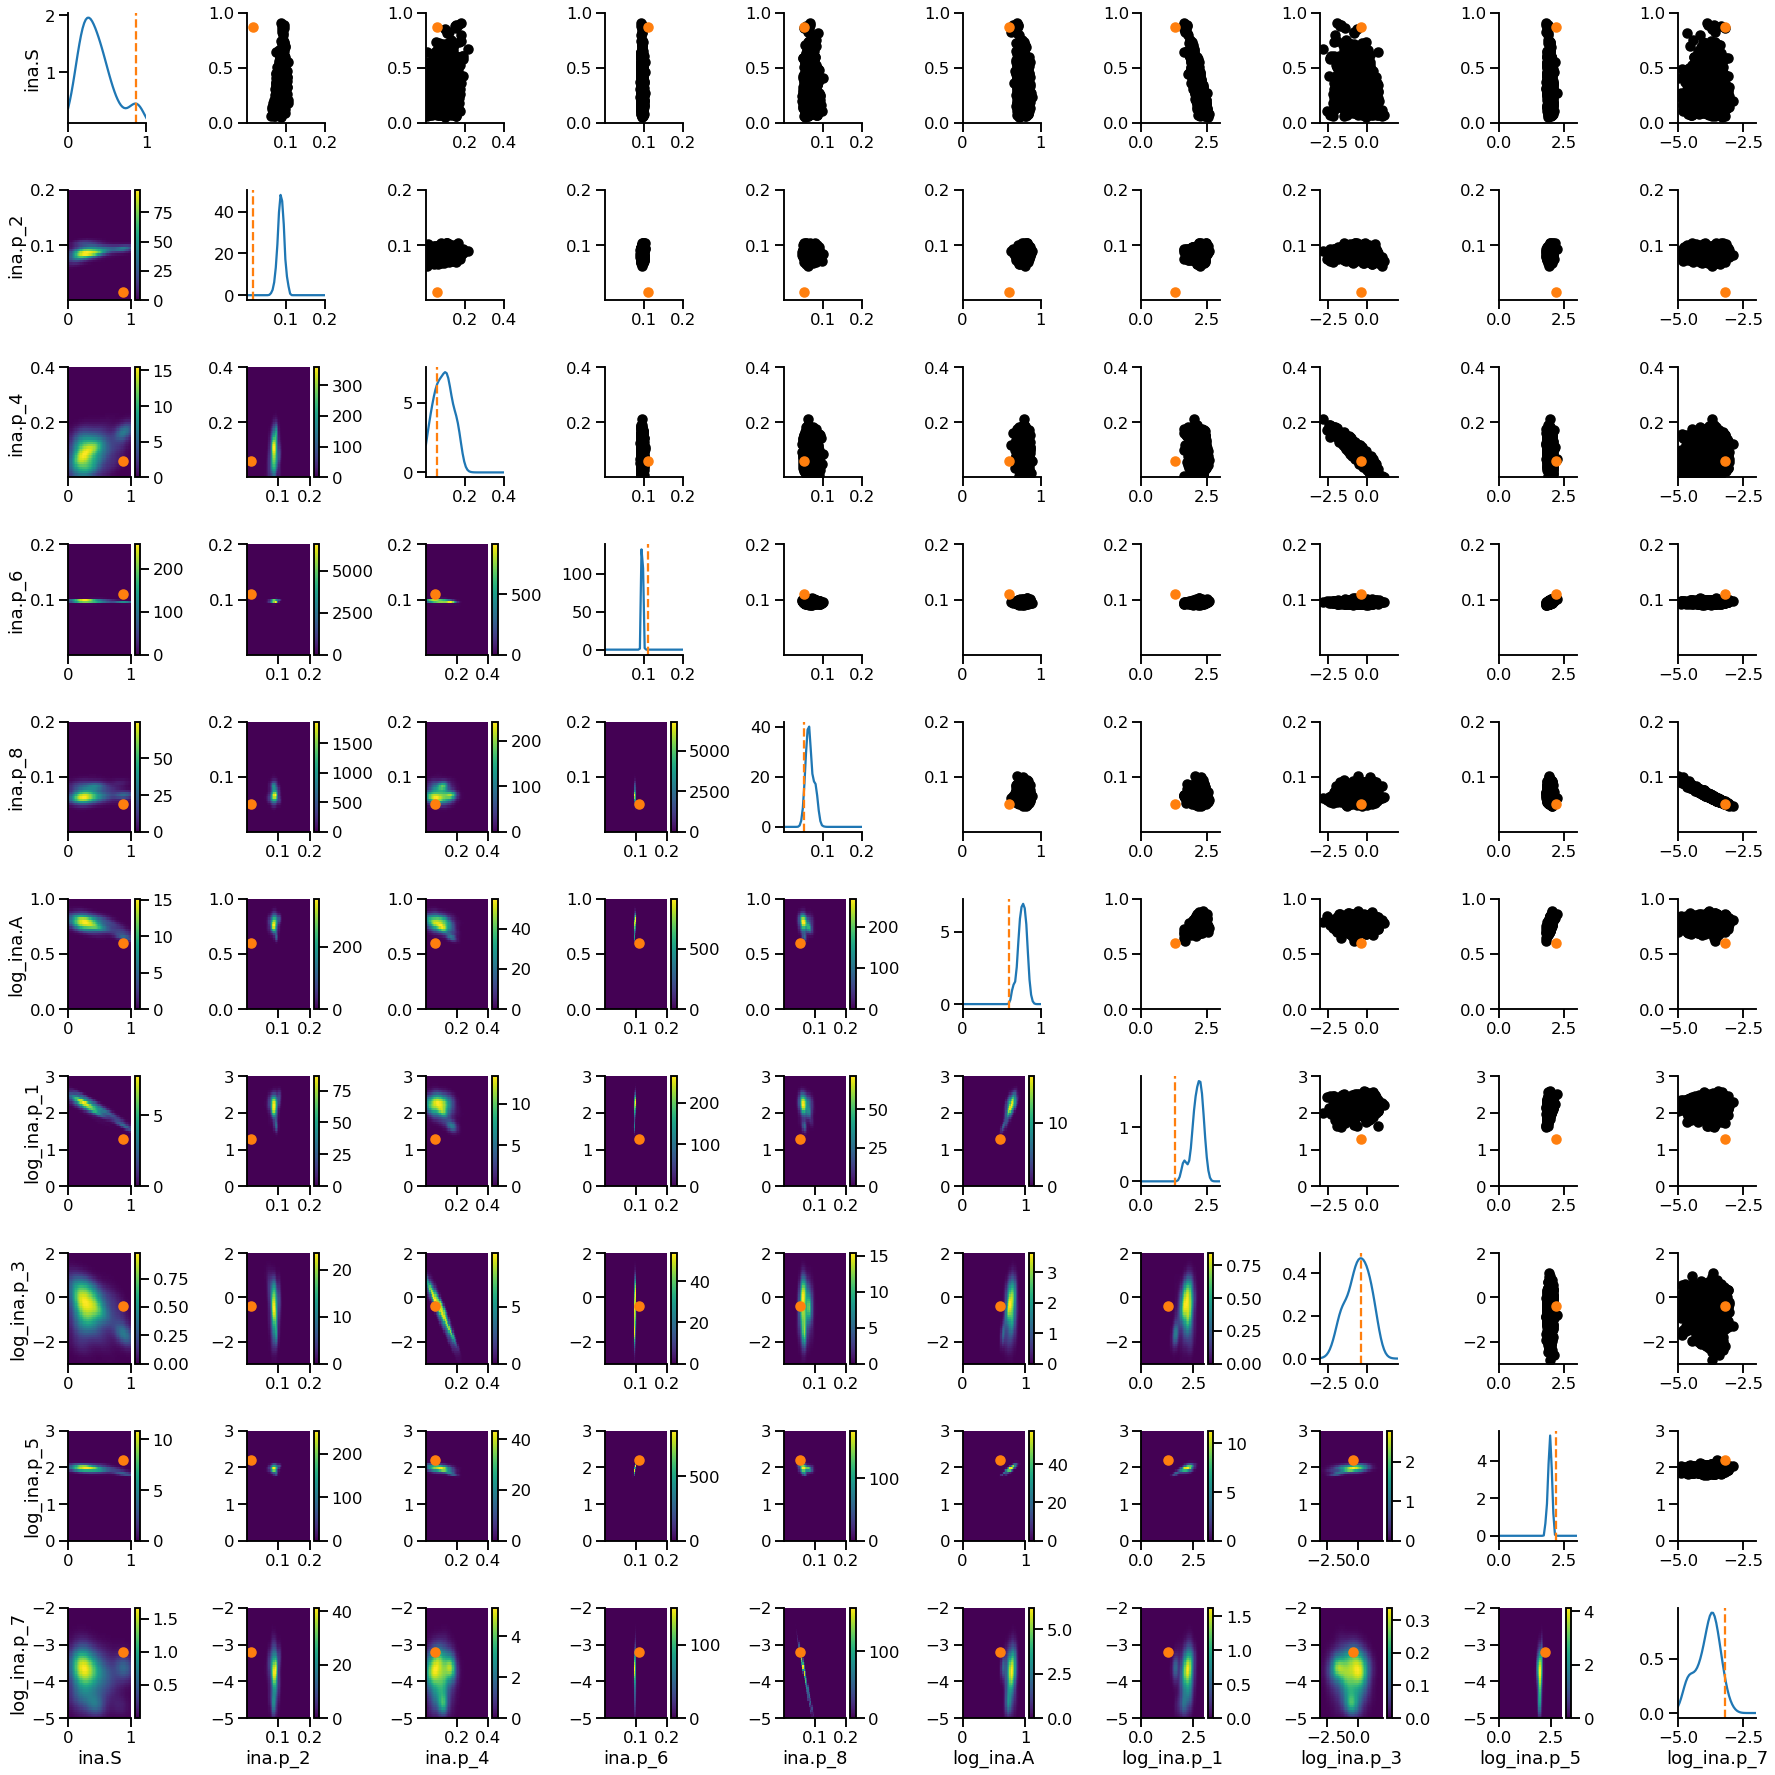

In [27]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

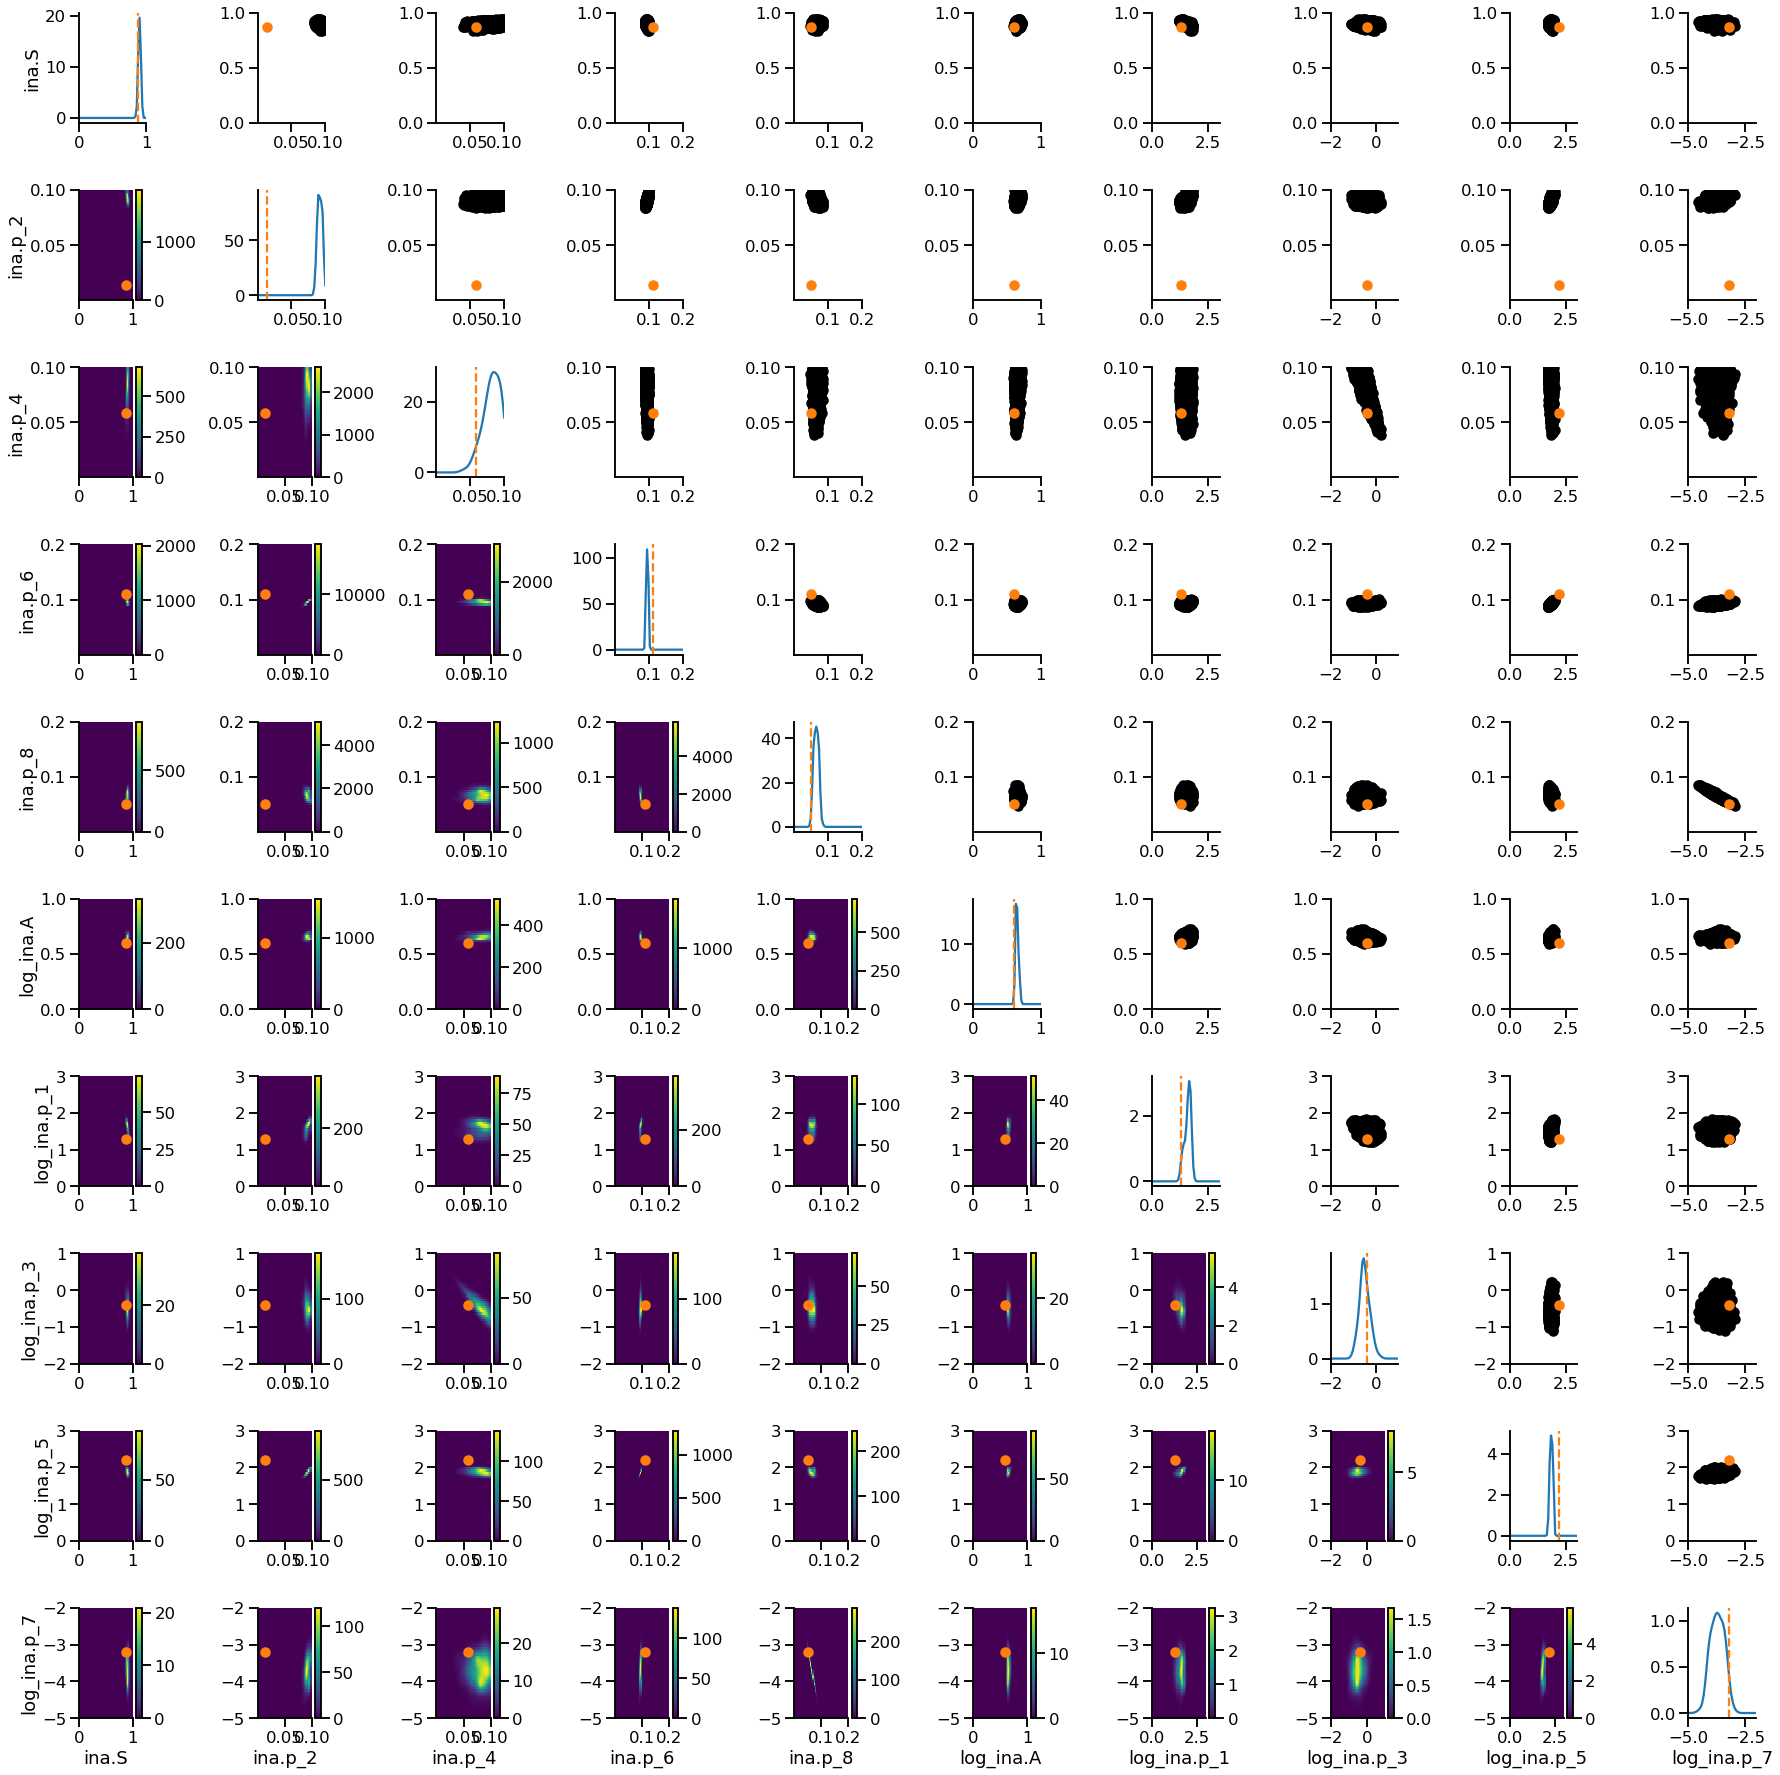

In [25]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [26]:
cv = (1+1/(4*2000))*df.std()/abs(df.mean())

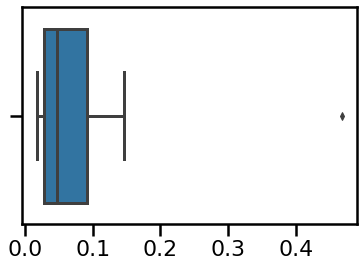

In [29]:
import seaborn as sns
sns.set_context('poster')

sns.boxplot(cv)